In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Import Data

In [19]:
# Load the labeled index data from csv
labeled_index = pd.read_csv("../data/labeled_data/quarterly_labeled_index.csv")

In [20]:
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())

## Z-Score Standardization

In [21]:
# Assuming your DataFrame is named df
features_columns = ['volatility', 'price_change', 'volume_change']

# Handle extreme value
labeled_index['volume_change'].replace([np.inf], 1e10, inplace=True)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected data
scaled_features = scaler.fit_transform(labeled_index[features_columns])

# Replace the original columns with the scaled values
labeled_index[features_columns] = scaled_features

In [22]:
# Save as csv
labeled_index.to_csv('../data/labeled_data/' + f"quarterly_labeled_index_standardized.csv", index=False)
print(f"Saved quarterly_labeled_index_standardized.csv")

Saved quarterly_labeled_index_standardized.csv


## Build the model

In [63]:
# Call TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
shap_values_list = []
best_params_list = []

for train_index, val_test_index in tscv.split(quarters):
    val_index = val_test_index[:int(len(val_test_index) * 0.5)]
    test_index = val_test_index[int(len(val_test_index) * 0.5):]
    train_quarters, val_quarters, test_quarters = quarters[train_index], quarters[val_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    val = labeled_index.loc[val_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_val = val[features_columns]
    y_val = val['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Hyperparameter Tuning with val
    if not all(label == 0 for label in y_val):
        param_grid = {"penalty": ['none', 'l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear', 'sag', 'saga']}
        grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=tscv, scoring='f1', verbose=2)
        grid_search.fit(X_val, y_val)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_params_list.append(best_params)
        print(f"Best Score: {best_score}")
        print("Grid search completed successfully.")
    else:
        best_params = best_params_list[-1]
    
    # Train the model
    model = LogisticRegression(penalty=best_params['penalty'], C=best_params['C'], solver=best_params['solver'])
    model.fit(X_train_resampled, y_train_resampled)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict probabilities on the test data
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels= [0,1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X_test)
    shap_values_list.append(shap_values)
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Val_Start': pd.to_datetime(val_quarters).min(),
        'Val_End': pd.to_datetime(val_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix, #[[TN, FP],[FN,TP]]
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Feature Importance
    feature_names = list(X_train.columns)
    feature_importance = model.coef_[0]
    for name, importance in zip(feature_names, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..................C=0.001, penalty=none, solver=sag; total time=   0.0s
[CV] END ..................C=0.001, penalty=non

[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.1s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...............C=10, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .....................C=10, penalty=none, solver=sag; total time=   0.0s
[CV] END .....................C=10, penalty=none, solver=sag; total time=   0.0s
[CV] END .....................C=10, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.0s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................

[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...................

[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=10, penalty=none, solver=saga; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=

[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.0s
Best Score: 0.0
Grid search completed successfully.
Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   

[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=0.1, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=0

[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ...................

In [64]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_benchmark.csv", index=False)
evaluation_df
#[[TN, FP],[FN,TP]]

,Train_Start,Train_End,Val_Start,Val_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,Accuracy,RMSE,MAPE,AUC-ROC,False Positive Rate,True Positive Rate,volatility_importance,price_change_importance,volume_change_importance
0,1998-03-31,2002-06-30,2002-09-30,2004-03-31,2004-06-30,2005-12-31,"[[59, 9], [1, 1]]",0.100000,0.500000,0.166667,0.857143,0.377964,inf,0.904412,"[0.0, 0.014705882352941176, 0.0294117647058823...","[0.0, 0.0, 0.0, 0.5, 0.5, 1.0, 1.0]",1.182574,-0.780970,-1.022684
1,1998-03-31,2005-12-31,2006-03-31,2007-09-30,2007-12-31,2009-06-30,"[[20, 22], [1, 27]]",0.551020,0.964286,0.701299,0.671429,0.573212,inf,0.730442,"[0.0, 0.023809523809523808, 0.0238095238095238...","[0.0, 0.0, 0.03571428571428571, 0.035714285714...",1.589881,-1.068282,-2.258488
2,1998-03-31,2009-06-30,2009-09-30,2011-03-31,2011-06-30,2012-12-31,"[[50, 14], [0, 6]]",0.300000,1.000000,0.461538,0.800000,0.447214,inf,0.945312,"[0.0, 0.0, 0.03125, 0.03125, 0.078125, 0.07812...","[0.0, 0.16666666666666666, 0.16666666666666666...",0.386613,-1.372396,-1.494471
3,1998-03-31,2012-12-31,2013-03-31,2014-09-30,2014-12-31,2016-06-30,"[[48, 11], [4, 7]]",0.388889,0.636364,0.482759,0.785714,0.462910,inf,0.718028,"[0.0, 0.0, 0.0, 0.01694915254237288, 0.0169491...","[0.0, 0.09090909090909091, 0.18181818181818182...",0.209453,-1.432583,-1.965105
4,1998-03-31,2016-06-30,2016-09-30,2018-03-31,2018-06-30,2019-12-31,"[[57, 12], [0, 1]]",0.076923,1.000000,0.142857,0.828571,0.414039,inf,0.985507,"[0.0, 0.014492753623188406, 0.0144927536231884...","[0.0, 0.0, 1.0, 1.0]",0.115044,-1.501287,-0.137772


## Shap Values
- color: how higher and lower values of the feature will affect the result
- X-axis: impact on output

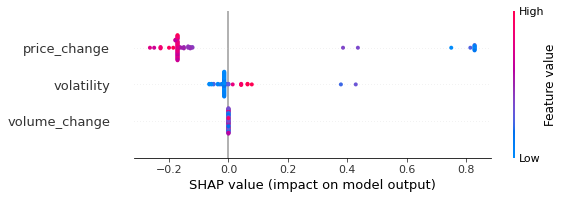

In [65]:
shap.plots.beeswarm(shap_values_list[4])

## Feature Importance

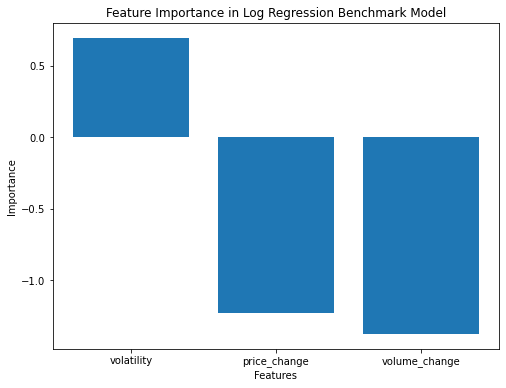

In [66]:
model_name = "Log Regression Benchmark"
plot_feature_importances(evaluation_df, model_name)

## AUC-ROC

In [67]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.8567402845860659


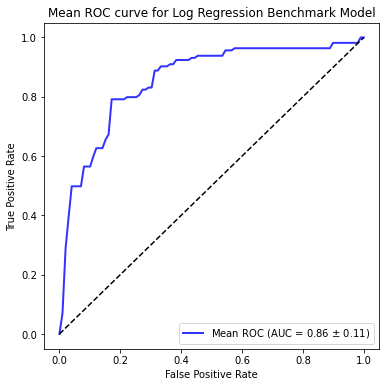

In [68]:
plot_roc_curve(evaluation_df, model_name)